# SMS Spam Classification – Notebook corregido
Este cuaderno soluciona los errores de forma y vacíos que provocaban fallos en el entrenamiento.

## 0. Descarga y limpieza del dataset

In [2]:
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Descarga (solo la primera vez)
!wget -q -O spam.csv https://raw.githubusercontent.com/javierherrera1996/IntroMachineLearning/refs/heads/main/TercerCorte/spam.csv

# Cargar CSV con codificación correcta y quedarnos con columnas relevantes
df = (pd.read_csv("spam.csv", encoding="ISO-8859-1")
        .rename(columns={'v1':'label', 'v2':'text'})
        [['label','text']])

# Eliminar filas con texto vacío o nulo
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1. Configuración y seed

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)


## 2. División Train/Test

In [4]:
y = df['label'].map({'ham':0,'spam':1})
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.2, stratify=y, random_state=42)

print(len(X_train),"train |", len(X_test),"test")


4457 train | 1115 test


## 3. Vectorización de texto con manejo seguro de dimensiones

In [5]:
MAX_TOKENS, MAX_LEN = 10000, 100
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation")
vectorizer.adapt(X_train.values)

def to_tensor(txt, label):
    txt = tf.expand_dims(txt, -1)          # (1,)
    seq = tf.squeeze(vectorizer(txt), axis=0) # (MAX_LEN,)
    return seq, label

batch = 32
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            .shuffle(10000)
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))
test_ds  = (tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))


## 4. Definición y entrenamiento del modelo

In [6]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8581 - loss: 0.4557 - val_accuracy: 0.8664 - val_loss: 0.3698
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8743 - loss: 0.3671 - val_accuracy: 0.8664 - val_loss: 0.3694
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8595 - loss: 0.3819 - val_accuracy: 0.8664 - val_loss: 0.3560
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8662 - loss: 0.3573 - val_accuracy: 0.8664 - val_loss: 0.3612
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8670 - loss: 0.3447 - val_accuracy: 0.8664 - val_loss: 0.3231


## 5. Curva de aprendizaje

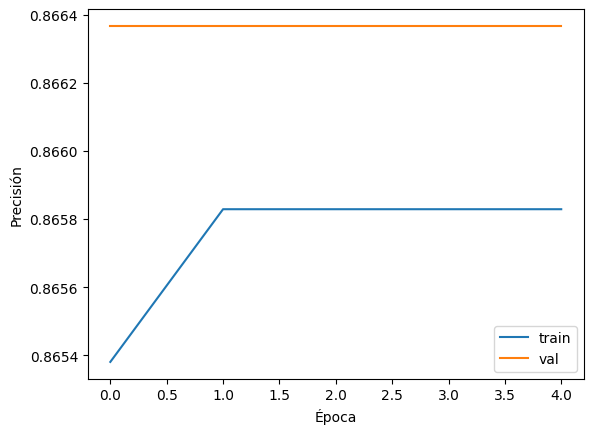

In [7]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()


## 6. Evaluación

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


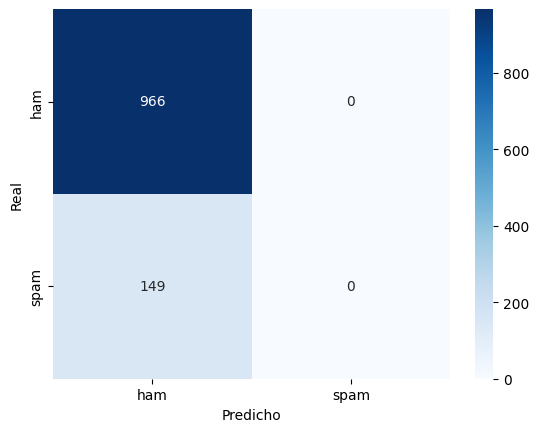

AUC: 0.9742729306487695


In [8]:
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)   # Umbral 0.4 para mejorar recall spam
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))


## 7. Próximos pasos
- Aumentar `epochs` si no hay sobreajuste.
- Probar `class_weight={0:1,1:2}` en `model.fit`.
- Cambiar la arquitectura a `Bidirectional(LSTM(32))` para capturar contexto.
- Usar embeddings preentrenados (GloVe) para menos datos.

In [9]:
# prompt: Aumentar epochs si no hay sobreajuste.

# If the validation accuracy is still increasing or staying close to the training accuracy,
# you can increase the number of epochs.
# Adjust the number of epochs in the model.fit call
history = model.fit(train_ds, validation_data=test_ds, epochs=10) # Increased epochs to 10 (example)

# You can further analyze the learning curve plot (Section 5) after increasing epochs
# to confirm whether further increases would be beneficial or lead to overfitting.

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8695 - loss: 0.3119 - val_accuracy: 0.8664 - val_loss: 0.2823
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8661 - loss: 0.2821 - val_accuracy: 0.8780 - val_loss: 0.2320
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8846 - loss: 0.2188 - val_accuracy: 0.9184 - val_loss: 0.1893
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9360 - loss: 0.1793 - val_accuracy: 0.9363 - val_loss: 0.1508
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9658 - loss: 0.1321 - val_accuracy: 0.9758 - val_loss: 0.1135
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9735 - loss: 0.1048 - val_accuracy: 0.9722 - val_loss: 0.0909
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9827 - loss: 0.0754 - val_accuracy: 0.9749 - val_loss: 0.0826
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9845 - loss: 0.0636 - val_accuracy: 

In [10]:
# prompt: Probar class_weight={0:1,1:2} en model.fit.

history = model.fit(train_ds, validation_data=test_ds, epochs=5, class_weight={0:1, 1:2})

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9872 - loss: 0.0813 - val_accuracy: 0.9776 - val_loss: 0.0746
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9868 - loss: 0.0792 - val_accuracy: 0.9839 - val_loss: 0.0619
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9911 - loss: 0.0539 - val_accuracy: 0.9839 - val_loss: 0.0594
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9881 - loss: 0.0912 - val_accuracy: 0.9830 - val_loss: 0.0593
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9910 - loss: 0.0570 - val_accuracy: 0.9839 - val_loss: 0.0584


In [11]:
# prompt: Cambiar la arquitectura a Bidirectional(LSTM(32)) para capturar contexto.

# Changing the architecture to Bidirectional(LSTM(32))
EMBED_DIM = 16 # Keep the same embedding dimension
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # Bidirectional LSTM layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# You may want to train for more epochs with this architecture
history = model.fit(train_ds, validation_data=test_ds, epochs=10) # Increased epochs for potentially better results

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.8762 - loss: 0.4297 - val_accuracy: 0.9713 - val_loss: 0.1183
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9796 - loss: 0.0866 - val_accuracy: 0.9830 - val_loss: 0.0639
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.9883 - loss: 0.0465 - val_accuracy: 0.9794 - val_loss: 0.0656
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9910 - loss: 0.0352 - val_accuracy: 0.9848 - val_loss: 0.0623
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9971 - loss: 0.0134 - val_accuracy: 0.9794 - val_loss: 0.0660
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.9965 - loss: 0.0114 - val_accuracy: 0.9830 - val_loss: 0.0670
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9991 - loss: 0.0050 - val_accuracy: 0.9839 - val_loss: 0.0706
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9995 - loss: 0.0050 - val_accura

In [ ]:
# prompt: Usar embeddings preentrenados (GloVe) para menos datos.

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Function to load GloVe embeddings
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings('glove.6B.50d.txt') # Using 50d embeddings for example

# Create embedding matrix
# Get the vocabulary from the TextVectorization layer
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

EMBED_DIM = 50 # Must match the dimension of the GloVe embeddings
embedding_matrix = np.zeros((MAX_TOKENS, EMBED_DIM))

for word, i in word_index.items():
    if i < MAX_TOKENS:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the model with GloVe embeddings
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM,
                              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                              input_length=MAX_LEN,
                              trainable=False), # Set trainable to False to use pre-trained weights
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with GloVe embeddings
history = model.fit(train_ds, validation_data=test_ds, epochs=10) # Adjust epochs as needed

# Continue with evaluation steps (Section 5 and 6)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()

y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)   # Umbral 0.4 para mejorar recall spam
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))

--2025-05-28 20:05:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-28 20:05:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-28 20:05:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov